## Importing libraries and packages

In [37]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import math # Needed for pi


## 1. Loading data :
Loading a single image, pose, and camera intrinsics from the Blender ficus dataset.
    

Image Shape: (128, 128, 3)

Camera-to-World Pose Matrix:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 4.]
 [0. 0. 0. 1.]]

Calculated Focal Length: 110.85125168440815


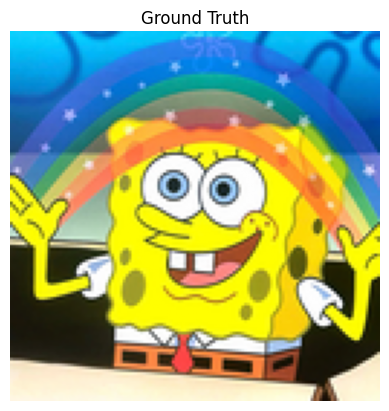

In [ ]:
def load_image_with_pose(dataset_dir, img_size=(128, 128)):

    # 1. Define a generic camera field of view (FOV).
    # 60 degrees is a common value. We convert it to radians.
    fov_degrees = 60.0
    camera_angle_x = fov_degrees * (math.pi / 180.0)

    # 2. Define a generic camera-to-world pose matrix.
    # This pose places the camera at (0, 0, 4) and looks towards the origin.
    transform_matrix = [
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 4.0],
        [0.0, 0.0, 0.0, 1.0]
    ]

    img = 'imagination.png'

    # 2. Construct the full path to the image file.
    img_path = os.path.join(dataset_dir, img)

    # 3. Load and process the image (same as before).
    image = Image.open(img_path).resize(img_size, Image.LANCZOS)
    image = np.array(image) / 255.0 # Normalize to [0, 1]

    # Extract RGB channels (assumes input is RGBA).
    rgb = image[..., :3]

    # The pose is the camera-to-world transformation matrix.
    pose = np.array(transform_matrix)

    # The focal length is calculated from the camera's horizontal field of view.
    focal = 0.5 * img_size[0] / np.tan(0.5 * camera_angle_x)

    return rgb, pose, focal


# Path to the base directory of your dataset.
dataset_base_dir = 'data/'

# Load the image and its corresponding, hardcoded camera data.
image, camera_to_world, focal_length = load_image_with_pose(dataset_base_dir, img_size=(128, 128))
height, width = image.shape[:2]

# Print the loaded data to verify
print("Image Shape:", image.shape)
print("\nCamera-to-World Pose Matrix:\n", camera_to_world)
print("\nCalculated Focal Length:", focal_length)

# Display the image
plt.imshow(image)
plt.title('Ground Truth')
plt.axis('off')
plt.show()

## 2. Ray Generation
This step connects the 2D image to the 3D world. For every pixel in the 128x128 image, it calculates a unique 3D ray.
Each ray has an origin (the camera's 3D location) and a direction vector that points from the camera, through that pixel and out into the scene. That results in a set of 10,000 rays, one for each pixel

In [39]:
def generate_camera_rays(height, width, focal_length, camera_to_world):
    # Create a grid of pixel coordinates (i: x-axis, j: y-axis)
    i, j = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')

    # Compute ray directions in camera space
    x = (i - width / 2) / focal_length
    y = -(j - height / 2) / focal_length
    z = -np.ones_like(x)
    directions_camera = np.stack([x, y, z], axis=-1)  # Shape: (H, W, 3)

    # Transform ray directions to world space
    directions_world = directions_camera @ camera_to_world[:3, :3].T

    # All rays originate from the camera origin in world space
    origins_world = np.broadcast_to(camera_to_world[:3, 3], directions_world.shape)

    return origins_world, directions_world

ray_origins, ray_directions = generate_camera_rays(height, width, focal_length, camera_to_world)


## 3. Point Sampling Along Rays
The neural network needs 3D points to evaluate, not just rays. This function takes each of the 10,000 rays and samples 32 distinct 3D points (x, y, z) along its path.
These points are spaced evenly between a near and a far boundary, defining the volume in space where the object is expected to be.


In [40]:

def sample_points_along_rays(ray_origins, ray_directions, near, far, num_samples):
    z_values = np.linspace(near, far, num_samples)
    points = ray_origins[..., None, :] + ray_directions[..., None, :] * z_values[None, None, :, None]
    return points, z_values

num_samples_per_ray = 32
near_bound, far_bound = 2.0, 6.0
sampled_points, z_values = sample_points_along_rays(ray_origins, ray_directions, near_bound, far_bound, num_samples_per_ray)


In [41]:

# def sample_points_along_rays(ray_origins, ray_directions, near, far, num_samples):
#     z_values = np.linspace(near, far, num_samples)
#     points = ray_origins[..., None, :] + ray_directions[..., None, :] * z_values[None, None, :, None]
#     return points, z_values

# def positional_encoding(x, num_freqs=6):
#     encoded_features = [x]
#     freqs = 2.**torch.arange(num_freqs, device=x.device) * torch.pi
#     for freq in freqs:
#         encoded_features.append(torch.sin(x * freq))
#         encoded_features.append(torch.cos(x * freq))
#     return torch.cat(encoded_features, dim=-1)

# # Example integration
# num_samples_per_ray = 32
# near_bound, far_bound = 2.0, 6.0

# # Sample points
# sampled_points, z_values = sample_points_along_rays(ray_origins, ray_directions, near_bound, far_bound, num_samples_per_ray)

# # Convert sampled points to torch tensor for positional encoding
# sampled_points_torch = torch.from_numpy(sampled_points).float()

# # Apply positional encoding
# encoded_points = positional_encoding(sampled_points_torch, num_freqs=6)

# # Now encoded_points can be passed into a neural network for further processing.


## Neural Network Definition
This is the core of the NeRF: a simple neural network. Its job is to act as a "function of the scene." It takes a single 3D coordinate (x, y, z) as input and predicts two things at that specific point in space: its color (r, g, b) and its density (sigma). A high density means the point is opaque, while a low density means it's transparent.

In [42]:
class NeRFNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 4)  # Output: (r, g, b, sigma)
        )

    def forward(self, x):
        return self.mlp(x)

# Instantiate the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeRFNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

## 5. Volume Rendering Function
Volume rendering simulates the way light passes through a semi-transparent medium (like fog, smoke, or 3D scenes) and accumulates color and opacity along a ray.

This is how an image is created from the Neural Network's predictions. For a single ray, it takes the 32 predicted colors and densities from the sampled points. Using the volume rendering equation, it composites them together, correctly blending the colors based on their density and distance. Points closer to the camera can block (occlude) points further away. The final output is a single pixel color for that ray.



In [43]:


def volume_render_radiance_field(rgb_sigma, z_values, ray_directions):
    """
    Args:
        rgb_sigma (Tensor): Raw output from the network of shape (num_rays, num_samples, 4).
                            The last channel is sigma (density), and the first three are RGB.
        z_values (Tensor): Sampled depth values along each ray, shape (num_samples,).
        ray_directions (Tensor): Ray directions, shape (num_rays, 3).

    Returns:
        rgb_map (Tensor): Rendered RGB color for each ray, shape (num_rays, 3).
    """
    # Separate RGB and density (sigma), applying activation functions
    rgb = torch.sigmoid(rgb_sigma[..., :3])          # (num_rays, num_samples, 3)
    # sigma = F.relu(rgb_sigma[..., 3])                # (num_rays, num_samples)
    sigma = F.softplus(rgb_sigma[..., 3])    # (num_rays, num_samples)

    # Compute distances between consecutive samples along each ray
    dists = z_values[1:] - z_values[:-1]             # (num_samples - 1,)
    dists = torch.cat([dists, torch.tensor([1e10], device=z_values.device)])  # (num_samples,)
    dists = dists.unsqueeze(0).expand(ray_directions.shape[0], -1)            # (num_rays, num_samples)

    # Scale distances by the length of each ray
    ray_lengths = torch.norm(ray_directions, dim=-1, keepdim=True)           # (num_rays, 1)
    dists = dists * ray_lengths                                              # (num_rays, num_samples)

    # Compute alpha values from sigma
    alpha = 1.0 - torch.exp(-sigma * dists)                                  # (num_rays, num_samples)

    # Compute transmittance (T) and sample weights
    T = torch.cumprod(
        torch.cat([
            torch.ones((alpha.shape[0], 1), device=alpha.device),
            1.0 - alpha + 1e-10
        ], dim=-1),
        dim=-1
    )[:, :-1]

    weights = alpha * T                                                      # (num_rays, num_samples)

    # Composite RGB values using the weights
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)                    # (num_rays, 3)

    return rgb_map


## 6. Prepare Training Data
To train efficiently on a GPU, the data (sampled points, ray directions, and target pixel colors) is "flattened" from 120x120 structure into long, one-dimensional lists.
It also converts the NumPy arrays into PyTorch Tensors.

In [44]:

# Flatten rays and image for batch processing
num_rays = height * width

points_flat = torch.from_numpy(sampled_points.reshape(-1, num_samples_per_ray, 3)).float().to(device)
ray_directions_flat = torch.from_numpy(ray_directions.reshape(-1, 3)).float().to(device)
target_rgb_flat = torch.from_numpy(image.reshape(-1, 3)).float().to(device)

z_values_tensor = torch.from_numpy(z_values).float().to(device)

# Flatten rays and image for batch processing
num_rays = height * width




In [45]:

# # Convert sampled points to tensor and apply positional encoding
# sampled_points_tensor = torch.from_numpy(sampled_points).float().to(device)
# encoded_points = positional_encoding(sampled_points_tensor, num_freqs=6)

# # Flatten the encoded points for batch processing
# points_flat = encoded_points.reshape(-1, num_samples_per_ray, encoded_points.shape[-1])

# ray_directions_flat = torch.from_numpy(ray_directions.reshape(-1, 3)).float().to(device)
# target_rgb_flat = torch.from_numpy(image.reshape(-1, 3)).float().to(device)

# z_values_tensor = torch.from_numpy(z_values).float().to(device)


## 7. Training Loop
This is where the learning happens. The loop repeats num_training_steps times, and in each step it:
- Forward Pass: Feeds all the sampled 3D points to the MLP to get color and density predictions.
- Render: Uses the volume rendering function to turn those predictions into a full image.
- Calculate Loss: Compares the rendered image with the ground truth image using Mean Squared Error (MSE) to see how "wrong" the prediction is.
- Optimize: Uses the error to calculate how to adjust the MLP's weights to make a better prediction in the next step (this is backpropagation).

In [46]:

num_training_steps = 5000
for step in tqdm(range(num_training_steps), desc="Training NeRF"):
    # Predict color and density for all points along all rays
    rgb_sigma = model(points_flat)  # (num_rays, num_samples, 4)
    rgb_sigma = rgb_sigma.view(-1, num_samples_per_ray, 4)

    # Volume render to get final pixel colors
    rendered_rgb = volume_render_radiance_field(rgb_sigma, z_values_tensor, ray_directions_flat)

    # Compute loss
    loss = F.mse_loss(rendered_rgb, target_rgb_flat)

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 100 == 0:
        print(f"Step {step:4d} | Loss: {loss.item():.6f}")


Training NeRF:   0%|          | 5/5000 [00:00<02:06, 39.60it/s]

Step    0 | Loss: 0.137929


Training NeRF:   2%|▏         | 110/5000 [00:02<01:39, 49.09it/s]

Step  100 | Loss: 0.050193


Training NeRF:   4%|▍         | 210/5000 [00:04<01:36, 49.57it/s]

Step  200 | Loss: 0.040399


Training NeRF:   6%|▌         | 310/5000 [00:06<01:35, 49.20it/s]

Step  300 | Loss: 0.036411


Training NeRF:   8%|▊         | 410/5000 [00:08<01:33, 49.17it/s]

Step  400 | Loss: 0.033782


Training NeRF:  10%|█         | 510/5000 [00:10<01:32, 48.34it/s]

Step  500 | Loss: 0.031675


Training NeRF:  12%|█▏        | 610/5000 [00:12<01:28, 49.35it/s]

Step  600 | Loss: 0.030152


Training NeRF:  14%|█▍        | 710/5000 [00:14<01:26, 49.45it/s]

Step  700 | Loss: 0.028648


Training NeRF:  16%|█▌        | 810/5000 [00:16<01:25, 49.02it/s]

Step  800 | Loss: 0.027229


Training NeRF:  18%|█▊        | 910/5000 [00:18<01:23, 48.80it/s]

Step  900 | Loss: 0.026918


Training NeRF:  20%|██        | 1010/5000 [00:20<01:22, 48.53it/s]

Step 1000 | Loss: 0.025959


Training NeRF:  22%|██▏       | 1110/5000 [00:22<01:19, 48.74it/s]

Step 1100 | Loss: 0.025099


Training NeRF:  24%|██▍       | 1210/5000 [00:24<01:17, 49.04it/s]

Step 1200 | Loss: 0.024618


Training NeRF:  26%|██▌       | 1310/5000 [00:26<01:15, 48.90it/s]

Step 1300 | Loss: 0.024442


Training NeRF:  28%|██▊       | 1410/5000 [00:28<01:13, 48.95it/s]

Step 1400 | Loss: 0.024323


Training NeRF:  30%|███       | 1510/5000 [00:30<01:12, 48.31it/s]

Step 1500 | Loss: 0.023612


Training NeRF:  32%|███▏      | 1610/5000 [00:32<01:10, 48.16it/s]

Step 1600 | Loss: 0.022794


Training NeRF:  34%|███▍      | 1710/5000 [00:34<01:07, 48.74it/s]

Step 1700 | Loss: 0.022674


Training NeRF:  36%|███▌      | 1810/5000 [00:36<01:05, 48.84it/s]

Step 1800 | Loss: 0.022605


Training NeRF:  38%|███▊      | 1910/5000 [00:39<01:03, 48.81it/s]

Step 1900 | Loss: 0.022563


Training NeRF:  40%|████      | 2010/5000 [00:41<01:01, 48.70it/s]

Step 2000 | Loss: 0.021484


Training NeRF:  42%|████▏     | 2110/5000 [00:43<00:59, 48.75it/s]

Step 2100 | Loss: 0.021257


Training NeRF:  44%|████▍     | 2210/5000 [00:45<00:57, 48.21it/s]

Step 2200 | Loss: 0.021179


Training NeRF:  46%|████▌     | 2310/5000 [00:47<00:55, 48.56it/s]

Step 2300 | Loss: 0.020545


Training NeRF:  48%|████▊     | 2410/5000 [00:49<00:53, 48.21it/s]

Step 2400 | Loss: 0.020617


Training NeRF:  50%|█████     | 2510/5000 [00:51<00:51, 48.45it/s]

Step 2500 | Loss: 0.020306


Training NeRF:  52%|█████▏    | 2610/5000 [00:53<00:49, 47.89it/s]

Step 2600 | Loss: 0.020463


Training NeRF:  54%|█████▍    | 2710/5000 [00:55<00:47, 48.43it/s]

Step 2700 | Loss: 0.020346


Training NeRF:  56%|█████▌    | 2810/5000 [00:57<00:45, 47.89it/s]

Step 2800 | Loss: 0.020017


Training NeRF:  58%|█████▊    | 2910/5000 [00:59<00:43, 47.84it/s]

Step 2900 | Loss: 0.019894


Training NeRF:  60%|██████    | 3010/5000 [01:01<00:41, 47.79it/s]

Step 3000 | Loss: 0.019201


Training NeRF:  62%|██████▏   | 3110/5000 [01:03<00:39, 47.67it/s]

Step 3100 | Loss: 0.019280


Training NeRF:  64%|██████▍   | 3210/5000 [01:06<00:37, 48.23it/s]

Step 3200 | Loss: 0.019740


Training NeRF:  66%|██████▌   | 3310/5000 [01:08<00:35, 48.22it/s]

Step 3300 | Loss: 0.019009


Training NeRF:  68%|██████▊   | 3410/5000 [01:10<00:33, 47.79it/s]

Step 3400 | Loss: 0.018742


Training NeRF:  70%|███████   | 3510/5000 [01:12<00:31, 47.95it/s]

Step 3500 | Loss: 0.018851


Training NeRF:  72%|███████▏  | 3610/5000 [01:14<00:28, 48.10it/s]

Step 3600 | Loss: 0.018531


Training NeRF:  74%|███████▍  | 3710/5000 [01:16<00:26, 48.20it/s]

Step 3700 | Loss: 0.018411


Training NeRF:  76%|███████▌  | 3810/5000 [01:18<00:25, 47.52it/s]

Step 3800 | Loss: 0.018481


Training NeRF:  78%|███████▊  | 3910/5000 [01:20<00:22, 48.08it/s]

Step 3900 | Loss: 0.018836


Training NeRF:  80%|████████  | 4010/5000 [01:22<00:21, 47.00it/s]

Step 4000 | Loss: 0.018445


Training NeRF:  82%|████████▏ | 4110/5000 [01:24<00:18, 47.53it/s]

Step 4100 | Loss: 0.018209


Training NeRF:  84%|████████▍ | 4210/5000 [01:26<00:16, 47.90it/s]

Step 4200 | Loss: 0.018045


Training NeRF:  86%|████████▌ | 4310/5000 [01:29<00:14, 47.75it/s]

Step 4300 | Loss: 0.018131


Training NeRF:  88%|████████▊ | 4410/5000 [01:31<00:12, 47.47it/s]

Step 4400 | Loss: 0.017746


Training NeRF:  90%|█████████ | 4510/5000 [01:33<00:10, 47.18it/s]

Step 4500 | Loss: 0.017404


Training NeRF:  92%|█████████▏| 4610/5000 [01:35<00:08, 47.49it/s]

Step 4600 | Loss: 0.017497


Training NeRF:  94%|█████████▍| 4710/5000 [01:37<00:06, 48.04it/s]

Step 4700 | Loss: 0.017650


Training NeRF:  96%|█████████▌| 4810/5000 [01:39<00:03, 47.82it/s]

Step 4800 | Loss: 0.017806


Training NeRF:  98%|█████████▊| 4910/5000 [01:41<00:01, 47.47it/s]

Step 4900 | Loss: 0.016915


Training NeRF: 100%|██████████| 5000/5000 [01:43<00:00, 48.30it/s]


## 8. Visualization

After the training finishes, this final step takes the model's last rendered image, converts it back into a standard image format, and displays it next to the original ground truth image.


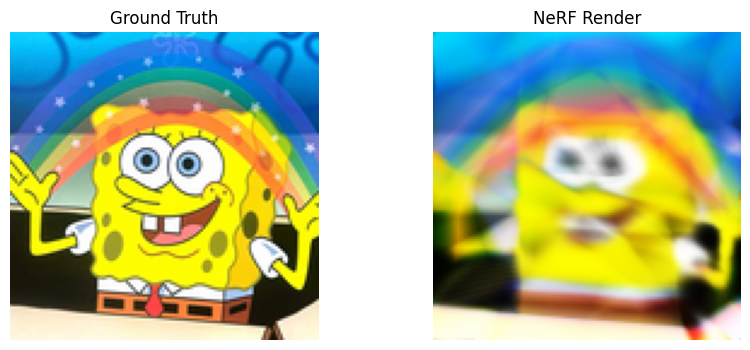

In [47]:
# Reshape the rendered image and display
rendered_image = rendered_rgb.detach().cpu().numpy().reshape(height, width, 3)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('NeRF Render')
plt.imshow(np.clip(rendered_image, 0, 1))
plt.axis('off')
plt.show()